In [ ]:
#!pip install transformers
#!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import transformers
from transformers import BertTokenizer, BertModel

import torch
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
data = pd.read_excel('/content/train.xlsx')
test = pd.read_excel('/content/test.xlsx')

In [ ]:
data = data.drop(columns = 'Unnamed: 0')
test = test.drop(columns = 'Unnamed: 0')
data.describe()

,tutor_rating,tutor_reviews,mean_price
count,3959.000000,4548.000000,4548.000000
mean,1.895933,2.989006,16.197949
std,2.280103,8.516939,10.485108
min,0.000000,0.000000,0.041667
25%,0.000000,0.000000,10.000000
50%,0.000000,0.000000,15.000000
75%,4.000000,2.000000,20.888889
max,5.000000,152.000000,100.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   предмет           4548 non-null   object 
 1   ФИО               4548 non-null   object 
 2   tutor_head_tags   4548 non-null   object 
 3   tutor_rating      3959 non-null   float64
 4   tutor_reviews     4548 non-null   int64  
 5   description       4547 non-null   object 
 6   experience_desc   2171 non-null   object 
 7   Education_1       4548 non-null   object 
 8   Desc_Education_1  4472 non-null   object 
 9   Education_2       781 non-null    object 
 10  Desc_Education_2  777 non-null    object 
 11  Education_3       106 non-null    object 
 12  Desc_Education_3  105 non-null    object 
 13  Education_4       16 non-null     object 
 14  Desc_Education_4  16 non-null     object 
 15  Ученая степень 1  76 non-null     object 
 16  Ученое звание 1   35 non-null     object 


Уберем столбцы, где почти все пропуски, т.к. они не несут в себе важную информацию, а так же ФИО не влияет на зарплату

In [ ]:
data = data.drop(columns = ['Education_3', 'Education_4', 'Desc_Education_3','Desc_Education_4', 'Desc_Education_5', 'Desc_Education_6', 'Education_5', 'Education_6', 'Ученая степень 2', 'Ученое звание 2', 'ФИО'])
test = test.drop(columns = ['Education_3', 'Education_4', 'Desc_Education_3','Desc_Education_4', 'Desc_Education_5', 'Desc_Education_6', 'Education_5', 'Education_6', 'Ученая степень 2', 'Ученое звание 2', 'ФИО'])

In [ ]:
data = data.drop(columns = ['Ученая степень 1', 'Ученое звание 1'])
test = test.drop(columns = ['Ученая степень 1', 'Ученое звание 1'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   предмет           4548 non-null   object 
 1   tutor_head_tags   4548 non-null   object 
 2   tutor_rating      3959 non-null   float64
 3   tutor_reviews     4548 non-null   int64  
 4   description       4547 non-null   object 
 5   experience_desc   2171 non-null   object 
 6   Education_1       4548 non-null   object 
 7   Desc_Education_1  4472 non-null   object 
 8   Education_2       781 non-null    object 
 9   Desc_Education_2  777 non-null    object 
 10  status            4535 non-null   object 
 11  experience        4523 non-null   object 
 12  categories        4548 non-null   object 
 13  mean_price        4548 non-null   float64
dtypes: float64(2), int64(1), object(11)
memory usage: 497.6+ KB


Заполним пропуски

In [ ]:
data.isna().sum()

,0
предмет,0
tutor_head_tags,0
tutor_rating,589
tutor_reviews,0
description,1
experience_desc,2377
Education_1,0
Desc_Education_1,76
Education_2,3767
Desc_Education_2,3771


Если tutor_rating пропущена, то это должен быть новый пользователь и рейтинга у него нет

In [ ]:
data['tutor_rating']

,tutor_rating
0,5.0
1,4.0
2,0.0
3,4.0
4,0.0
...,...
4543,4.0
4544,0.0
4545,0.0
4546,0.0


In [ ]:
data['tutor_rating'] = data['tutor_rating'].fillna(0)

test['tutor_rating'] = test['tutor_rating'].fillna(0)

Если description пропущено, то можем просто заемнить его пустой строкой

In [ ]:
data['description'] = data['description'].fillna('')

test['description'] = test['description'].fillna('')

Аналогично с experience_description и desc_eductation

In [ ]:
data['experience_desc'] = data['experience_desc'].fillna('')
data['Desc_Education_1'] = data['Desc_Education_1'].fillna('')
data['Desc_Education_2'] = data['Desc_Education_2'].fillna('')
# data['Desc_Education_3'] = data['Desc_Education_3'].fillna('')
# data['Desc_Education_4'] = data['Desc_Education_4'].fillna('')

test['experience_desc'] = test['experience_desc'].fillna('')
test['Desc_Education_1'] = test['Desc_Education_1'].fillna('')
test['Desc_Education_2'] = test['Desc_Education_2'].fillna('')
# test['Desc_Education_3'] = test['Desc_Education_3'].fillna('')
# test['Desc_Education_4'] = test['Desc_Education_4'].fillna('')

Если какое-то из образований пропущено, то, скорее всего, его просто нет

In [ ]:
data['Education_2'] = data['Education_2'].fillna('')
# data['Education_3'] = data['Education_3'].fillna('')
# # data['Education_4'] = data['Education_4'].fillna('')
# data['Ученая степень 1'] = data['Ученая степень 1'].fillna('')
# data['Ученое звание 1'] = data['Ученое звание 1'].fillna('')

test['Education_2'] = test['Education_2'].fillna('')
# test['Education_3'] = test['Education_3'].fillna('')
# test['Education_4'] = test['Education_4'].fillna('')
# test['Ученая степень 1'] = test['Ученая степень 1'].fillna('')
# test['Ученое звание 1'] = test['Ученое звание 1'].fillna('')

In [ ]:
data['status'] = data['status'].fillna('')

test['status'] = test['status'].fillna('')

Если experience не указан, тог можем предположин, что это новый репетитор без опыта работы

In [ ]:
data['experience'] = data['experience'].fillna('0 лет')

test['experience'] = test['experience'].fillna('0 лет')

In [ ]:
data.isna().sum()

,0
предмет,0
tutor_head_tags,0
tutor_rating,0
tutor_reviews,0
description,0
experience_desc,0
Education_1,0
Desc_Education_1,0
Education_2,0
Desc_Education_2,0


Теперь преобразуем каждый столбец


Теги репетитора кодируем с помощью one-hot-encoding

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# Разбиваем массивы на отдельные элементы
exploded_tags = data['tutor_head_tags'].explode().reset_index(drop=True)
# Создаем экземпляр MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Преобразуем каждый элемент в список
tags_list = [eval(tag) for tag in exploded_tags]
# Кодируем метки
encoded_tags = mlb.fit_transform(tags_list)
# Создаем новый столбец для каждой метки
for i, label in enumerate(mlb.classes_):
    data[label] = encoded_tags[:, i]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
exploded_tags = test['tutor_head_tags'].explode().reset_index(drop=True)
mlb = MultiLabelBinarizer()
tags_list = [eval(tag) for tag in exploded_tags]
encoded_tags = mlb.fit_transform(tags_list)
for i, label in enumerate(mlb.classes_):
    test[label] = encoded_tags[:, i]

In [ ]:
data = data.drop(columns = 'tutor_head_tags')

test = test.drop(columns = 'tutor_head_tags')

In [ ]:
data['предмет'].value_counts()

,count
предмет,
matematika,3685
informatika,863


Предмет так же кодируем с помощью OHE

In [ ]:
data['предмет'] = data['предмет'].replace({'matematika': 1, 'informatika': 0})

test['предмет'] = test['предмет'].replace({'matematika': 1, 'informatika': 0})

В колокне 'description' будет содержаться информация о том, написал ли свое описание репетитор

In [ ]:
 data['description'] = data['description'].map({'Репетитор не предоставил о себе дополнительных сведений': 1}).fillna(0)

 test['description'] = test['description'].map({'Репетитор не предоставил о себе дополнительных сведений': 1}).fillna(0)

Разделим описание образование на Год окончания, факлуьтет и специальность

In [ ]:
data['Год_окончания'] = data['Desc_Education_1'].str.extract(r'Год окончания: (\d+)')
data['Факультет'] = data['Desc_Education_1'].str.extract(r'Факультет: ([^,]+)')
data['Специальность'] = data['Desc_Education_1'].str.extract(r'Специальность: ([^,]+)')

test['Год_окончания'] = test['Desc_Education_1'].str.extract(r'Год окончания: (\d+)')
test['Факультет'] = test['Desc_Education_1'].str.extract(r'Факультет: ([^,]+)')
test['Специальность'] = test['Desc_Education_1'].str.extract(r'Специальность: ([^,]+)')

In [ ]:
data['Год_окончания_2'] = data['Desc_Education_2'].str.extract(r'Год окончания: (\d+)')
data['Факультет_2'] = data['Desc_Education_2'].str.extract(r'Факультет: ([^,]+)')
data['Специальность_2'] = data['Desc_Education_2'].str.extract(r'Специальность: ([^,]+)')

test['Год_окончания_2'] = test['Desc_Education_2'].str.extract(r'Год окончания: (\d+)')
test['Факультет_2'] = test['Desc_Education_2'].str.extract(r'Факультет: ([^,]+)')
test['Специальность_2'] = test['Desc_Education_2'].str.extract(r'Специальность: ([^,]+)')

In [ ]:
 #data['Год_окончания_3'] = data['Desc_Education_3'].str.extract(r'Год окончания: (\d+)')
# data['Факультет_3'] = data['Desc_Education_3'].str.extract(r'Факультет: ([^,]+)')
 #data['Специальность_3'] = data['Desc_Education_3'].str.extract(r'Специальность: ([^,]+)')
#test['Год_окончания_3'] = test['Desc_Education_3'].str.extract(r'Год окончания: (\d+)')
#test['Специальность_3'] = test['Desc_Education_3'].str.extract(r'Специальность: ([^,]+)')

In [ ]:
# data['Год_окончания_4'] = data['Desc_Education_4'].str.extract(r'Год окончания: (\d+)')
# data['Факультет_4'] = data['Desc_Education_4'].str.extract(r'Факультет: ([^,]+)')
# data['Специальность_4'] = data['Desc_Education_4'].str.extract(r'Специальность: ([^,]+)')

# test['Год_окончания_4'] = test['Desc_Education_4'].str.extract(r'Год окончания: (\d+)')
# test['Факультет_4'] = test['Desc_Education_4'].str.extract(r'Факультет: ([^,]+)')
# test['Специальность_4'] = test['Desc_Education_4'].str.extract(r'Специальность: ([^,]+)')

data = data.drop(columns = ['Desc_Education_1', 'Desc_Education_2'])

test = test.drop(columns = ['Desc_Education_1', 'Desc_Education_2'])

In [ ]:
data['Год_окончания'] = data['Год_окончания'].fillna(0)
data['Год_окончания_2'] = data['Год_окончания_2'].fillna(0)
# data['Год_окончания_3'] = data['Год_окончания_3'].fillna(0)
# data['Год_окончания_4'] = data['Год_окончания_4'].fillna(0)
data = data.fillna('')

test['Год_окончания'] = test['Год_окончания'].fillna(0)
test['Год_окончания_2'] = test['Год_окончания_2'].fillna(0)
# test['Год_окончания_3'] = test['Год_окончания_3'].fillna(0)
# test['Год_окончания_4'] = test['Год_окончания_4'].fillna(0)
test = test.fillna('')

Категории кодируем с помощью OHE

In [ ]:
# Применение explode к столбцу с категориями в обучающем наборе данных
exploded_tags_train = data['categories'].explode().reset_index(drop=True)

# Преобразование списка в массив строк
tags_list_train = [eval(tag) for tag in exploded_tags_train]

# Создание и обучение MultiLabelBinarizer на обучающем наборе данных
mlb = MultiLabelBinarizer()
encoded_tags_train = mlb.fit_transform(tags_list_train)

# Применение One-Hot Encoding на обучающем наборе данных
for i, label in enumerate(mlb.classes_):
    data[label] = encoded_tags_train[:, i]

# Удаление столбца с категориями из обучающего набора данных
data = data.drop(columns='categories')


exploded_tags_test = test['categories'].explode().reset_index(drop=True)
tags_list_test = [eval(tag) for tag in exploded_tags_test]
encoded_tags_test = mlb.transform(tags_list_test)
for i, label in enumerate(mlb.classes_):
    test[label] = encoded_tags_test[:, i]
test = test.drop(columns='categories')



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Студенты университетов группа'] will be ignored
  warnings.warn(


В experience нам нужно только число, оставим его

In [ ]:
data['experience'] = data['experience'].str.extract(r'(\d+)')

test['experience'] = test['experience'].str.extract(r'(\d+)')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 52 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   предмет                                                                          4548 non-null   int64  
 1   tutor_rating                                                                     4548 non-null   float64
 2   tutor_reviews                                                                    4548 non-null   int64  
 3   description                                                                      4548 non-null   float64
 4   experience_desc                                                                  4548 non-null   object 
 5   Education_1                                                                      4548 non-null   object 
 6   Educatio

Заполним пропуски

Если рейтинг репетитора - NaN, вероятно, у него нет отзывов и можем поставить 0 в эту колонку.

Аналогично предположим, что если experience = NaN, то он равен 0

In [ ]:
data['Год_окончания'] = data['Год_окончания'].astype(int)
data['Год_окончания_2'] = data['Год_окончания_2'].astype(int)
# data['Год_окончания_3'] = data['Год_окончания_3'].astype(int)
# data['Год_окончания_4'] = data['Год_окончания_4'].astype(int)
data['experience'] = data['experience'].astype(int)

test['Год_окончания'] = test['Год_окончания'].astype(int)
test['Год_окончания_2'] = test['Год_окончания_2'].astype(int)
# test['Год_окончания_3'] = test['Год_окончания_3'].astype(int)
# test['Год_окончания_4'] = test['Год_окончания_4'].astype(int)
test['experience'] = test['experience'].astype(int)

Здесь я попробовал закодировать с помощью CatBoostEncoder и получили результаты гораздо хуже (MSE вырос на 24)

In [ ]:
# import pandas as pd
# from category_encoders import CatBoostEncoder


# emb_columns = ['Education_1', 'Education_2', 'Education_3', 'Education_4', 'description', 'experience_desc', 'Ученая степень 1', 'Ученое звание 1', 'status', 'Факультет', 'Специальность', 'Факультет_2', 'Специальность_2', 'Факультет_3', 'Специальность_3', 'Факультет_4', 'Специальность_4']

# encoder = CatBoostEncoder(cols=emb_columns)

# encoded_data = encoder.fit_transform(data, data['mean_price'])

# data[emb_columns] = encoded_data[emb_columns]


# emb_columns = ['Education_1', 'Education_2', 'Education_3', 'Education_4', 'description', 'experience_desc', 'Ученая степень 1', 'Ученое звание 1', 'status', 'Факультет', 'Специальность', 'Факультет_2', 'Специальность_2', 'Факультет_3', 'Специальность_3', 'Факультет_4', 'Специальность_4']

# encoder = CatBoostEncoder(cols=emb_columns)

# encoded_data = encoder.fit_transform(data, data['mean_price'])

# test[emb_columns] = encoded_data[emb_columns]




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased").to(device)

Будем кодировать с помощью предобученного BERT, с помощью него мы можем учесть сам текст в описании репетитора, а так же опытным путем получили, что в нашем случае он работает лучше, чем OHE и CatBoostEncoder

In [ ]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=575).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    return embeddings[0]

In [ ]:
%%time
data["Education_1"] = data["Education_1"].apply(get_bert_embeddings)

test["Education_1"] = test["Education_1"].apply(get_bert_embeddings)

CPU times: user 1min 9s, sys: 352 ms, total: 1min 9s
Wall time: 1min 22s


In [ ]:
%%time
data["Education_2"] = data["Education_2"].apply(get_bert_embeddings)

test["Education_2"] = test["Education_2"].apply(get_bert_embeddings)

CPU times: user 1min, sys: 173 ms, total: 1min
Wall time: 1min 4s


In [ ]:
# %%time
# data["Education_3"] = data["Education_3"].apply(get_bert_embeddings)

# test["Education_3"] = test["Education_3"].apply(get_bert_embeddings)

In [ ]:
# %%time
# data["Education_4"] = data["Education_4"].apply(get_bert_embeddings)

# test["Education_4"] = test["Education_4"].apply(get_bert_embeddings)

In [ ]:
max_length = 512

data["description"] = data["description"].apply(lambda x: x[:max_length] if isinstance(x, str) else '')
data["experience_desc"] = data["experience_desc"].apply(lambda x: x[:max_length] if isinstance(x, str) else '')

test["description"] = test["description"].apply(lambda x: x[:max_length] if isinstance(x, str) else '')
test["experience_desc"] = test["experience_desc"].apply(lambda x: x[:max_length] if isinstance(x, str) else '')


In [ ]:
%%time
data["description"] = data["description"].apply(get_bert_embeddings)
data["experience_desc"] = data["experience_desc"].apply(get_bert_embeddings)

test["description"] = test["description"].apply(get_bert_embeddings)
test["experience_desc"] = test["experience_desc"].apply(get_bert_embeddings)

CPU times: user 2min 7s, sys: 396 ms, total: 2min 8s
Wall time: 2min 18s


In [ ]:
%%time
# data["Ученая степень 1"] = data["Ученая степень 1"].apply(get_bert_embeddings)
# data["Ученое звание 1"] = data["Ученое звание 1"].apply(get_bert_embeddings)
data['status'] = data['status'].apply(get_bert_embeddings)

# test["Ученая степень 1"] = test["Ученая степень 1"].apply(get_bert_embeddings)
# test["Ученое звание 1"] = test["Ученое звание 1"].apply(get_bert_embeddings)
test['status'] = test['status'].apply(get_bert_embeddings)

CPU times: user 1min 1s, sys: 136 ms, total: 1min 1s
Wall time: 1min 2s


In [ ]:
%%time
data["Факультет"] = data["Факультет"].apply(get_bert_embeddings)
data["Специальность"] = data["Специальность"].apply(get_bert_embeddings)

test["Факультет"] = test["Факультет"].apply(get_bert_embeddings)
test["Специальность"] = test["Специальность"].apply(get_bert_embeddings)

CPU times: user 2min 2s, sys: 299 ms, total: 2min 3s
Wall time: 2min 3s


In [ ]:
%%time
data["Факультет_2"] = data["Факультет_2"].apply(get_bert_embeddings)
data["Специальность_2"] = data["Специальность_2"].apply(get_bert_embeddings)

test["Факультет_2"] = test["Факультет_2"].apply(get_bert_embeddings)
test["Специальность_2"] = test["Специальность_2"].apply(get_bert_embeddings)

CPU times: user 1min 59s, sys: 325 ms, total: 1min 59s
Wall time: 1min 59s


In [ ]:
data

,предмет,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Education_2,status,experience,mean_price,...,Студенты университетов в паре,Школьники с 1 по 4 класс,Школьники с 1 по 4 класс в паре,Школьники с 1 по 4 класс группа,"Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты в паре","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты группа",Школьники с 5 по 9 класс,Школьники с 5 по 9 класс в паре,Школьники с 5 по 9 класс группа
0,1,5.0,2,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.24656117, -0.042266667, -0.16662845, -0.280...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.13209805, 0.01904457, -0.13745566, 0.024669...",31,16.666667,...,0,0,0,0,1,0,0,1,0,0
1,1,4.0,7,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[-0.0026722872, 0.0025400305, -0.19151776, -0....","[0.033495363, 0.008373867, -0.18259296, -0.041...","[0.0015867423, 0.04019443, -0.08974729, -0.038...",8,11.666667,...,0,0,0,0,1,0,0,1,0,0
2,0,0.0,0,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.27011684, -0.43876013, -0.3668052, 0.021646...","[0.05722283, 0.011893911, -0.19617978, -0.0850...","[0.26747897, -0.18786845, -0.44754976, -0.1092...","[0.0015867423, 0.04019443, -0.08974729, -0.038...",11,23.333333,...,0,0,0,0,1,0,0,1,0,0
3,1,4.0,19,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.012212579, 0.0084087625, -0.122292526, -0.1...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[-0.0036443414, 0.04361283, -0.08343982, -0.00...",5,0.116667,...,0,1,0,0,1,0,0,1,0,0
4,1,0.0,0,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.3203539, -0.48803455, -0.2765971, 0.0509304...","[0.034512945, -0.00618839, -0.10463297, -0.075...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[-0.0036443414, 0.04361283, -0.08343982, -0.00...",19,16.666667,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,1,4.0,11,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.26776558, 0.08113125, -0.10478261, -0.10476...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[-0.0036443414, 0.04361283, -0.08343982, -0.00...",5,16.666667,...,0,1,0,0,1,0,0,1,0,0
4544,0,0.0,0,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.07574693, -0.23860742, -0.14794077, 0.18900...","[0.13777888, 0.06969793, -0.23144247, 0.051343...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.0015867423, 0.04019443, -0.08974729, -0.038...",30,33.333333,...,0,0,0,0,0,0,0,1,0,0
4545,0,0.0,0,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[-0.007578776, -0.38520017, 0.33168018, -0.347...","[0.107586704, -0.014726989, -0.16020343, -0.08...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.12876455, 0.011511735, -0.04721148, 0.01556...",6,23.333333,...,0,0,0,0,1,0,0,1,0,0
4546,0,0.0,0,"[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.031247333, -0.11071203, -0.304489, 0.006215...","[0.5383523, 0.18719424, 0.018957224, 0.0727657...","[0.30990767, 0.42106947, -0.07309379, -0.38381...","[0.12876455, 0.011511735, -0.04721148, 0.01556...",1,9.722222,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
# %%time
# data["Факультет_3"] = data["Факультет_3"].apply(get_bert_embeddings)
# data["Специальность_3"] = data["Специальность_3"].apply(get_bert_embeddings)

# test["Факультет_3"] = test["Факультет_3"].apply(get_bert_embeddings)
# test["Специальность_3"] = test["Специальность_3"].apply(get_bert_embeddings)

In [ ]:
# %%time
# data["Факультет_4"] = data["Факультет_4"].apply(get_bert_embeddings)
# data["Специальность_4"] = data["Специальность_4"].apply(get_bert_embeddings)

# test["Факультет_4"] = test["Факультет_4"].apply(get_bert_embeddings)
# test["Специальность_4"] = test["Специальность_4"].apply(get_bert_embeddings)

In [ ]:
emb_columns = ['Education_1', 'Education_2', 'description', 'experience_desc', 'status', 'Факультет', 'Специальность', 'Факультет_2', 'Специальность_2']

Наши модели не могут принимать массивы чисел на вход, поэтому разделим эти массивы, образовав новые признаки

In [ ]:
k = 0
for column in emb_columns:
  for i in range(768):
    data[f'feature_{i+1000*k}'] = data[column].apply(lambda x: x[i])
  k += 1

In [ ]:
k = 0
for column in emb_columns:
  for i in range(768):
    test[f'feature_{i+1000*k}'] = test[column].apply(lambda x: x[i])
  k += 1

In [ ]:
data = data.drop(columns = emb_columns)

test = test.drop(columns = emb_columns)

Будем использовать три модели:
- Линейная регрессия
- Random Forest
- Градиентный бустинг (в нашем случае CatBoost и LightGBM)


In [ ]:
y = data['mean_price']
X = data.drop(columns = 'mean_price')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

Подберем параметры

In [ ]:
# !pip install optuna

CatBoost

In [ ]:
# import optuna
# def objective_cat(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 900, 1600),
#         # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#         'depth': trial.suggest_int('depth', 4, 9),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e2),
#         'task_type' : 'GPU'
#     }

#     model = CatBoostRegressor(**params)
#     model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

#     y_pred = model.predict(X_val)
#     mse = mean_squared_error(y_val, y_pred)

#     return mse
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_cat, n_trials=100)
# print("Best parameters:", study.best_params)
# print("Best MSE:", study.best_value)


In [ ]:
params =  {'iterations': 1244,
           'learning_rate': 0.04526463173269921,
           'depth': 5,
           'l2_leaf_reg': 95.70751968265648,
           'border_count': 42}

In [ ]:
cat = CatBoostRegressor(verbose = 100,**params, task_type = 'GPU')
cat.fit(X_train,y_train)
y_pred = cat.predict(X_val)
cat_mse = mean_squared_error(y_val, y_pred)

print("Mean Squared Error:", cat_mse)

0:	learn: 10.3477813	total: 165ms	remaining: 3m 25s
100:	learn: 9.0180058	total: 7.28s	remaining: 1m 22s
200:	learn: 8.5767167	total: 15.1s	remaining: 1m 18s
300:	learn: 8.2422772	total: 23s	remaining: 1m 12s
400:	learn: 8.0061543	total: 29.6s	remaining: 1m 2s
500:	learn: 7.7991418	total: 37.3s	remaining: 55.3s
600:	learn: 7.6195845	total: 44.1s	remaining: 47.2s
700:	learn: 7.4611795	total: 51.8s	remaining: 40.1s
800:	learn: 7.3152586	total: 58.4s	remaining: 32.3s
900:	learn: 7.1810246	total: 1m 5s	remaining: 24.9s
1000:	learn: 7.0683720	total: 1m 12s	remaining: 17.5s
1100:	learn: 6.9627426	total: 1m 19s	remaining: 10.3s
1200:	learn: 6.8672471	total: 1m 26s	remaining: 3.11s
1243:	learn: 6.8251930	total: 1m 30s	remaining: 0us
Mean Squared Error: 89.88182314709117


Подбирать параметры для RandomForest оказалось очень долго, т.к. нельзя обучать с использованием GPU, поэтому проверили со стандартными параметрами и получили скор хуже (как правило, подбор параметров у RandomForest не дает столь значительный прирост)

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rf_mse = mean_squared_error(y_val, y_pred)

print("Mean Squared Error:", rf_mse)

Mean Squared Error: 95.5339736371957


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

lr_mse = mean_squared_error(y_val, y_pred)

print("Mean Squared Error:", lr_mse)


Mean Squared Error: 1.4363631597498796e+18


Видим, что CatBoost показал лучшие результаты

Submission

In [ ]:
cat = CatBoostRegressor(verbose = 100,**params, task_type = 'GPU')
cat.fit(X, y)

subm = cat.predict(test)

0:	learn: 10.4337836	total: 171ms	remaining: 3m 32s
100:	learn: 9.1740865	total: 7.97s	remaining: 1m 30s
200:	learn: 8.7841916	total: 14.9s	remaining: 1m 17s
300:	learn: 8.4557896	total: 22.5s	remaining: 1m 10s
400:	learn: 8.2379167	total: 29.7s	remaining: 1m 2s
500:	learn: 8.0897551	total: 36.8s	remaining: 54.6s
600:	learn: 7.9638197	total: 43.9s	remaining: 47s
700:	learn: 7.8524040	total: 50.7s	remaining: 39.3s
800:	learn: 7.7639399	total: 58.2s	remaining: 32.2s
900:	learn: 7.6686302	total: 1m 4s	remaining: 24.6s
1000:	learn: 7.5959624	total: 1m 11s	remaining: 17.4s
1100:	learn: 7.5235215	total: 1m 17s	remaining: 10.1s
1200:	learn: 7.4559590	total: 1m 25s	remaining: 3.05s
1243:	learn: 7.4247926	total: 1m 27s	remaining: 0us


In [ ]:
submission = pd.read_csv('/content/sample_submit.csv')

In [ ]:
submission['mean_price'] = subm

In [ ]:
submission.to_csv('submission.csv', index=False)

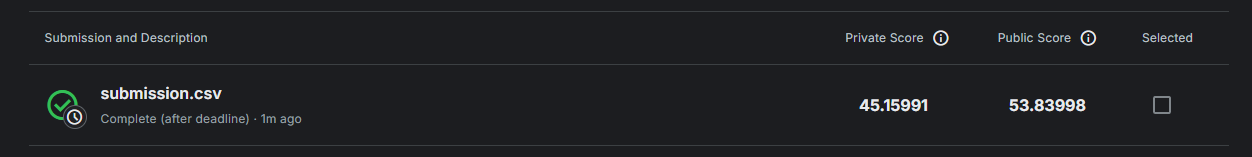